### Read Kv map from Figure 11 in Gregg and Carter (2011)

In [1]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
from scipy.cluster.vq import vq
import scipy.interpolate as interp
import scipy.io as sio
import scipy.misc as spy

import warnings
warnings.filterwarnings("ignore")

In [2]:
image = spy.imread('Ascension_kv.png')

In [3]:
np.shape(image)

(1156, 1304, 4)

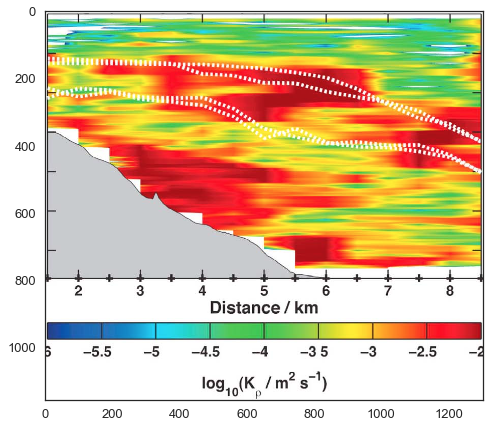

In [4]:
sns.set_style('white')
sns.set_context('talk')

plt.imshow(image)

(786, 1291, 4)


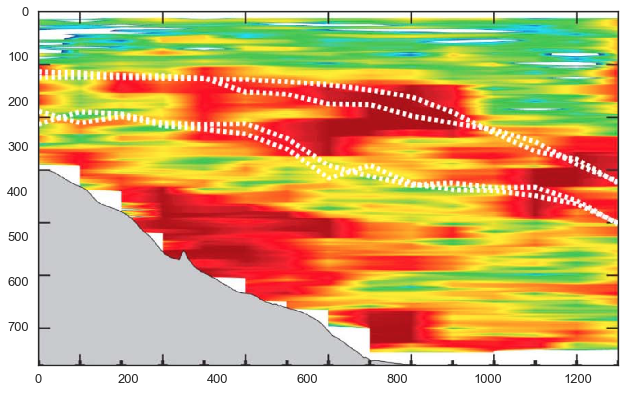

In [5]:
kvmap = image[7:793,6:1297,:]
plt.imshow(kvmap)
print(np.shape(kvmap))

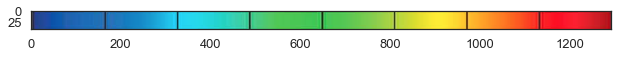

In [6]:
cbar = image[930:970,3:1296,:]
plt.imshow(cbar)

Concatenated colorbar


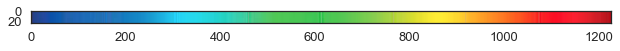

Original colorbar


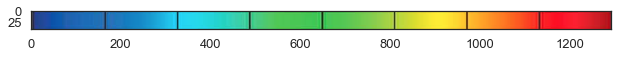

In [7]:
#get rid of black bars, pick the 8 sections individually
grad1 = cbar[5:30,4:161,:]
grad2 = cbar[5:30,171:323,:]
grad3 = cbar[5:30,330:480,:]
grad4 = cbar[5:30,490:645,:]
grad5 = cbar[5:30,653:804,:]
grad6 = cbar[5:30,812:964,:]
grad7 = cbar[5:30,973:1128,:]
grad8 = cbar[5:30,1135:-3,:]

gradient = np.concatenate((grad1, grad2, grad3, grad4, grad5, grad6, grad7, grad8), axis=1)
rgb_list = np.mean(gradient, axis=0)

print('Concatenated colorbar')
plt.imshow(gradient)
plt.show()
print('Original colorbar')
plt.imshow(cbar)
plt.show()



### Interpolate pixels into Gregg and Carter's original grid

The original grid has a resolution of 5 m x 0.5 km (vertical and along thalweg). I need to find the conversion pixels to meters in each direction to recreate that grid. I will split the image into cells of Z pixels by X pixels. But first, I need to mask all gray and all white (land and rim lines).

To build that mask i need to ask if red, green AND blue are a certain value ()

How many pixels in 1 "horizontal" km? Lines are about 6 pixels wide. There are about 184$\pm$3 pixels in 1 km

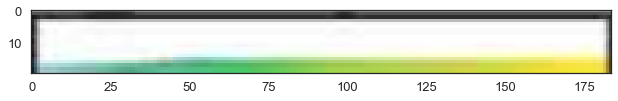

In [8]:
def_1km = kvmap[0:20,93:277,:]
plt.imshow(def_1km)

How many pixels in 100 "vertical" meters? There are 117$\pm$3 pixels per 100 m along the vertical axis.

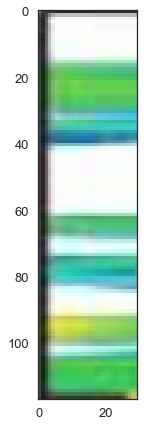

In [9]:
def_100m = kvmap[2:119,0:30,:]
plt.imshow(def_100m)

**Mask everything on the grey scale** 

Greys have all the same values for red, green and blue. So let's mask everything that has r==g and g==b.

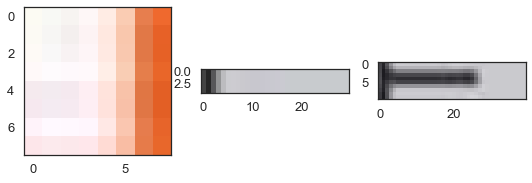

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(9,3))

white = kvmap[132:140,17:25,:]
grey = kvmap[730:735, 0:30,:]
black = kvmap[700:710, 0:40, :]

ax1.imshow(white)
ax2.imshow(grey)
ax3.imshow(black)

plt.show()

#print(white)
#print(grey)
#print(black)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


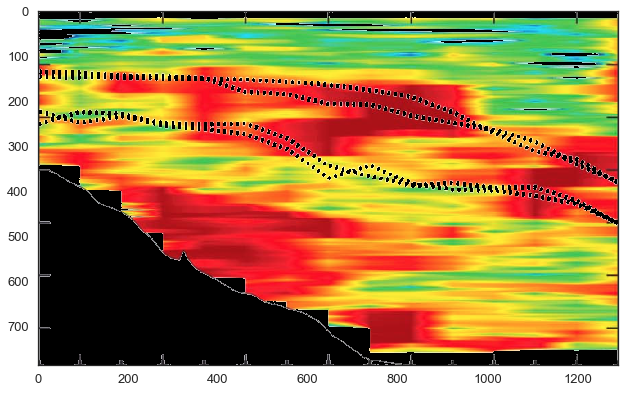

In [11]:
# mask all white and gray pixels reprresnting land, NaNs and the rim
kvmap_masked = np.copy(kvmap)
kvmap_masked = kvmap_masked.astype('float')

for ii in range(np.shape(kvmap)[0]):
    for jj in range(np.shape(kvmap)[1]):
        # Mask greys
        if 190<=kvmap_masked[ii,jj,0]<=210 and 190<=kvmap_masked[ii,jj,1]<=210 and 190<=kvmap_masked[ii,jj,2]<=210: 
            kvmap_masked[ii,jj,0:3]=np.nan
        elif kvmap_masked[ii,jj,0]==67 and kvmap_masked[ii,jj,1]==67 and kvmap_masked[ii,jj,2]==67: 
            kvmap_masked[ii,jj,0:3]=np.nan
        elif kvmap_masked[ii,jj,0]==37 and kvmap_masked[ii,jj,1]==37 and kvmap_masked[ii,jj,2]==37: 
            kvmap_masked[ii,jj,0:3]=np.nan
        elif kvmap_masked[ii,jj,0]==87 and kvmap_masked[ii,jj,1]==87 and kvmap_masked[ii,jj,2]==87: 
            kvmap_masked[ii,jj,0:3]=np.nan
        # mask whites
        elif 180<=kvmap_masked[ii,jj,0]<=255 and 180<=kvmap_masked[ii,jj,1]<=255 and 180<=kvmap_masked[ii,jj,2]<=255: 
            kvmap_masked[ii,jj,0:3]=np.nan
        
        else:
            continue
        
plt.imshow(kvmap_masked.astype(int))
plt.show()

In [12]:
# Bin data into their original 14 stations along the canyon axis (their plot is interpolated)
size = np.shape(kvmap_masked)
kvmap_binned = np.zeros((int(size[0]/6),int(size[1]/92),4))

kk = 0
mm = 0

for ii in range(int(size[0]/6)):
    mm = 0
    for jj in range(int(size[1]/92)):
        #print(ii,jj,kk,mm)
        kvmap_binned[ii,jj,0] = np.nanmean(kvmap_masked[kk:kk+6, mm:mm+92,0])
        #print(kvmap_binned[ii,jj,0])
        kvmap_binned[ii,jj,1] = np.nanmean(kvmap_masked[kk:kk+6, mm:mm+92,1])
        #print(kvmap_binned[ii,jj,1])
        kvmap_binned[ii,jj,2] = np.nanmean(kvmap_masked[kk:kk+6, mm:mm+92,2])
        #print(kvmap_binned[ii,jj,2])
        kvmap_binned[ii,jj,3] = np.nanmean(kvmap_masked[kk:kk+6, mm:mm+92,3])
        mm = mm + 92
    kk = kk + 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


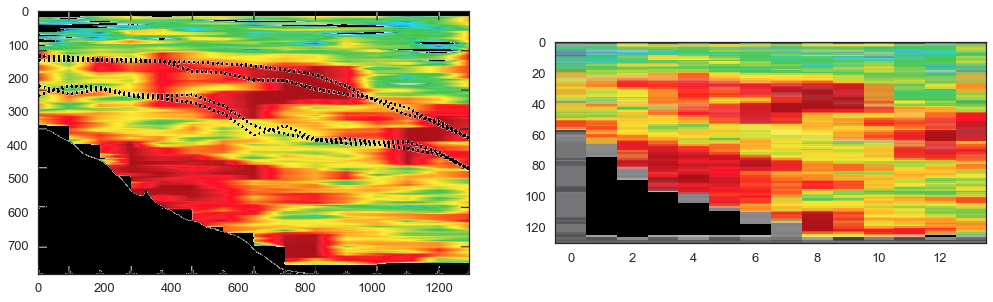

In [13]:
fig, ax = plt.subplots(1,2,figsize=(17,9))

ax[0].imshow(kvmap_masked.astype(int))
ax[1].imshow(kvmap_binned.astype(int), aspect=0.05)
plt.show()

# At this point kvmap_binned nad kvmap_masked have NaNs

In [14]:
# Get rid of NaN's which turn into negative values when we apply int 
kvmap_cleanBinned = np.where(kvmap_binned.astype(int)<0,0, kvmap_binned.astype(int))

for ii in range(np.shape(kvmap_cleanBinned)[0]):
    for jj in range(np.shape(kvmap_cleanBinned)[1]):
        # Mask greys
        if (kvmap_cleanBinned[ii,jj,0]==kvmap_cleanBinned[ii,jj,1] and 
            kvmap_cleanBinned[ii,jj,1]==kvmap_cleanBinned[ii,jj,2]): 
            kvmap_cleanBinned[ii,jj,0:3]= 0
        elif (115<=kvmap_cleanBinned[ii,jj,0]<=135 and 115<=kvmap_cleanBinned[ii,jj,1]<=135 and 
              115<=kvmap_cleanBinned[ii,jj,2]<=135): 
              kvmap_cleanBinned[ii,jj,0:3]= 0
        elif (130<=kvmap_cleanBinned[ii,jj,0]<=150 and 130<=kvmap_cleanBinned[ii,jj,1]<=150 and 
              130<=kvmap_cleanBinned[ii,jj,2]<=150): 
              kvmap_cleanBinned[ii,jj,0:3]= 0
        elif (80<=kvmap_cleanBinned[ii,jj,0]<=101 and 80<=kvmap_cleanBinned[ii,jj,1]<=101 and 
              80<=kvmap_cleanBinned[ii,jj,2]<=101): 
              kvmap_cleanBinned[ii,jj,0:3]= 0
        elif (99<=kvmap_cleanBinned[ii,jj,0]<=115 and 99<=kvmap_cleanBinned[ii,jj,1]<=115 and 
              99<=kvmap_cleanBinned[ii,jj,2]<=115): 
              kvmap_cleanBinned[ii,jj,0:3]= 0
        elif (160<=kvmap_cleanBinned[ii,jj,0]<=185 and 160<=kvmap_cleanBinned[ii,jj,1]<=185 and 
              160<=kvmap_cleanBinned[ii,jj,2]<=185): 
              kvmap_cleanBinned[ii,jj,0:3]= 0
        elif (150<=kvmap_cleanBinned[ii,jj,0]<=170 and 150<=kvmap_cleanBinned[ii,jj,1]<=170 and 
              150<=kvmap_cleanBinned[ii,jj,2]<=170): 
              kvmap_cleanBinned[ii,jj,0:3]= 0
        elif (159<=kvmap_cleanBinned[ii,jj,0]<=176 and 159<=kvmap_cleanBinned[ii,jj,1]<=176 and 
              159<=kvmap_cleanBinned[ii,jj,2]<=176): 
              kvmap_cleanBinned[ii,jj,0:3]= 0
        else:
            continue

kvmap_cleanMasked = np.where(kvmap_masked.astype(int)<0,0, kvmap_masked.astype(int))


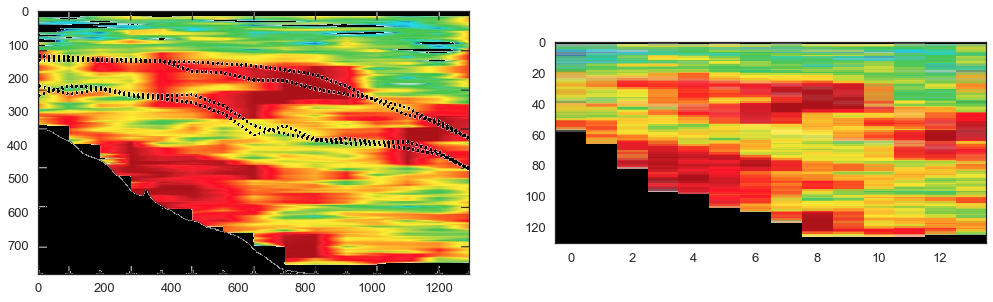

In [15]:
fig, ax = plt.subplots(1,2,figsize=(17,9))

ax[0].imshow(kvmap_cleanMasked.astype(int))
ax[1].imshow(kvmap_cleanBinned.astype(int), aspect=0.05)
plt.show()

# It's ok they they look the same

In [16]:
# define a colormap based on the colobar in the png, based on an answer in
# https://stackoverflow.com/questions/3720840/how-to-reverse-color-map-image-to-scalar-values

import matplotlib.cm as cm
import scipy.cluster.vq as scv

def rgb2hex(r, g, b):
    '''r, g, b, are the red, green, blue values of a color. They should be integers between 0 and 255.
    This function returns the hexadecimal code for the color. '''
    return('#{:02x}{:02x}{:02x}'.format( r, g , b ))

def colormap2arr(arr,cmap):    
    # http://stackoverflow.com/questions/3720840/how-to-reverse-color-map-image-to-scalar-values/3722674#3722674
    vmin = -6.1
    vmax = -2.
    precision = 0.01
    resolution = 1 + vmax-vmin/precision
    print(resolution)
    sample = np.linspace(vmin,vmax,resolution)

    # create code_book from sample
    cmap = LinearSegmentedColormap.from_list('Gregg2011', hex_list)
    norm = Normalize()
    code_book = scv.whiten(cmap(norm(sample)))
     
    # Reshape arr, all the 4-tuples in a long list...
    arr2=arr.reshape((arr.shape[0]*arr.shape[1],arr.shape[2]))

    # Use vector quantization to shift the values in arr2 to the nearest point in
    # the code book
    arr_white = scv.whiten(arr2)
    ind, dist = scv.vq(arr_white,code_book)
    # ind is an array of length arr2, holding the code book index for
    # each observation. (arr2 are the "observations".)
   
    values = sample[ind]
    values=values.reshape(arr.shape[0],arr.shape[1])
    values=values[::-1]
    return values, dist


#values = sample[indices]


In [17]:
# Find rgb values of pixels in the image's colorbar to make a colormap

hex_list = []
for ii in range(len(rgb_list)):
    listy = hex_list.append(rgb2hex(rgb_list.astype(int)[ii,0],
                                    rgb_list.astype(int)[ii,1],
                                    rgb_list.astype(int)[ii,2]))
    
cmap = LinearSegmentedColormap.from_list('Gregg2011', hex_list)

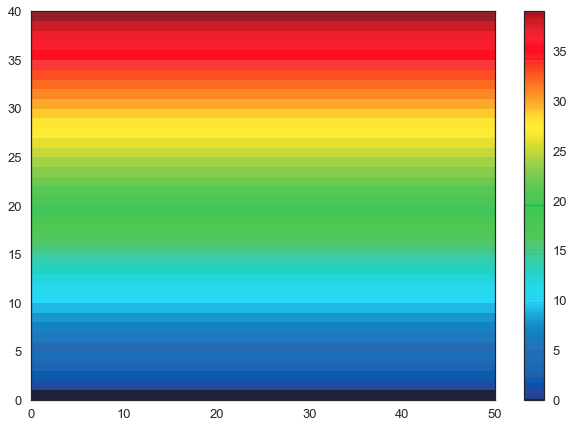

In [18]:
# Check that the colomap I build is working
x,y, = np.meshgrid(np.arange(50), np.arange(40))
pc = plt.pcolor(y, cmap=cmap)
plt.colorbar(pc)

609.0


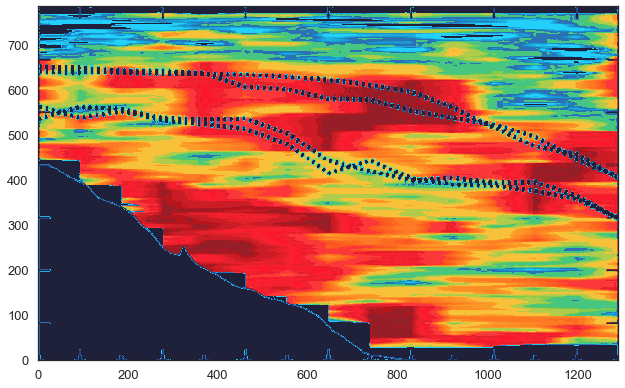

In [19]:
values, dist=colormap2arr(kvmap_cleanMasked[:,:],cmap)    

# Check that it works:
plt.imshow(values,interpolation='none', cmap=cmap, origin='lower')
plt.show()

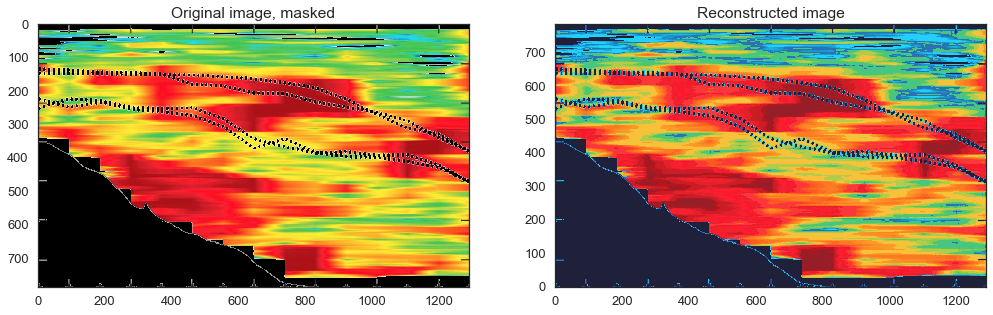

In [20]:
fig, ax = plt.subplots(1,2,figsize=(17,9))

ax[0].imshow(kvmap_cleanMasked[:,:])
ax[1].imshow(values,interpolation='none', cmap=cmap, origin='lower')
ax[0].set_title('Original image, masked')
ax[1].set_title('Reconstructed image')

plt.show()

609.0


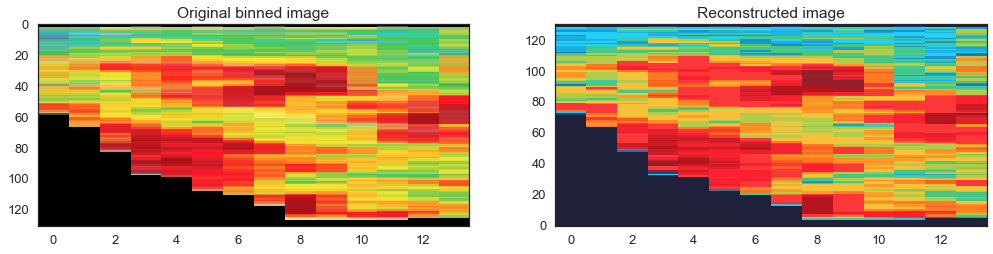

In [21]:
values_binned, dist=colormap2arr(kvmap_cleanBinned[:,:],cmap)    

fig, ax = plt.subplots(1,2,figsize=(17,9))

ax[0].imshow(kvmap_cleanBinned.astype(int)[:,:], aspect=0.05)
ax[1].imshow(values_binned,interpolation='none', cmap=cmap, origin='lower', aspect=0.05)
ax[0].set_title('Original binned image')
ax[1].set_title('Reconstructed image')

plt.show()

Text(0.5,1,'Reconstructed binned')

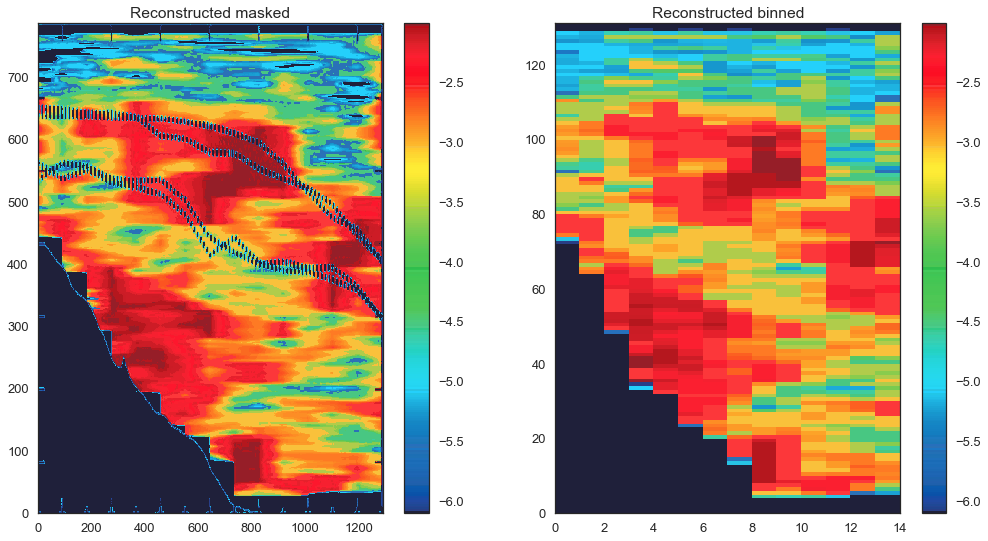

In [22]:
# plot pcolors

fig, ax = plt.subplots(1,2,figsize=(17,9))

pc0 = ax[0].pcolor(values, cmap=cmap)
plt.colorbar(pc0, ax = ax[0])
pc1 = ax[1].pcolor(values_binned, cmap=cmap)
plt.colorbar(pc1, ax = ax[1])
#ax[1].set_aspect(0.05)

ax[0].set_title('Reconstructed masked')
ax[1].set_title('Reconstructed binned')


Text(0.5,0,'distance form head / km')

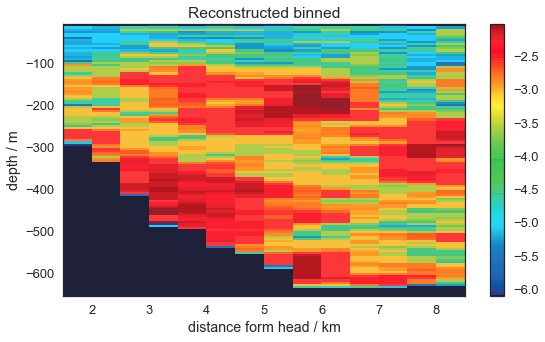

In [23]:
# plot pcolors
fig, ax = plt.subplots(1,1,figsize=(9,5))
pc1 = ax.pcolor((np.arange(3,18,1))/2,np.arange(-655,0,5),values_binned, cmap=cmap)
plt.colorbar(pc1, ax = ax)
#ax[1].set_aspect(0.05)

ax.set_title('Reconstructed binned')
ax.set_ylabel('depth / m')
ax.set_xlabel('distance form head / km')


-2.01348684211


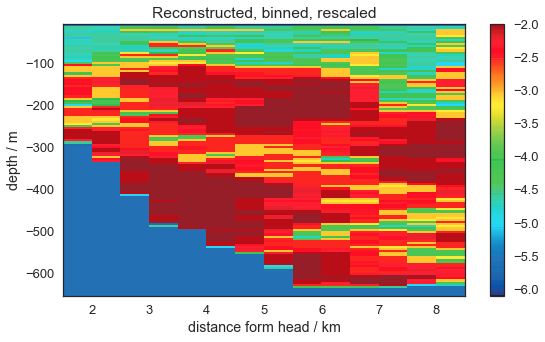

In [54]:
# Rescale values to match original figure. The image is "too blue" at the surface. 
# log10(Kv) should be around -4.5 to -4, not -5 tp -4.5

values_binned_rescaled = values_binned+0.5

# plot pcolors
fig, ax = plt.subplots(1,1,figsize=(9,5))
pc1 = ax.pcolor((np.arange(3,18,1))/2,np.arange(-655,0,5),values_binned_rescaled, 
                vmin=-6.1, vmax=-2, cmap=cmap)
plt.colorbar(pc1, ax = ax)
#ax[1].set_aspect(0.05)

ax.set_title('Reconstructed, binned, rescaled')
ax.set_ylabel('depth / m')
ax.set_xlabel('distance form head / km')

# Check that there aren't values larger than the max in the original colorbar (-2)
print(np.max(values_binned))

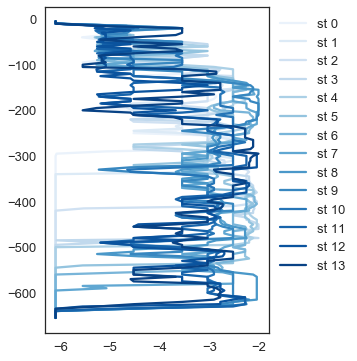

In [55]:
# Plot profiles - For the binned image 20±4 pixels per 100 m, profiles each 0.5 km
fig, ax = plt.subplots(1,1,figsize=(4,6))

labels = ['st %d' %ii for ii in range(np.shape(values_binned_rescaled)[1])]

sns.set_palette("Blues", 14)
for jj, lab in zip(range(np.shape(values_binned)[1]), labels):
    ax.plot(values_binned[:,jj],np.arange(-655,0,5), '-',label=lab)

ax.legend(bbox_to_anchor=(1,1))

In [56]:
values_binned_masked = np.ma.masked_equal(values_binned_rescaled, -6.1+0.5)

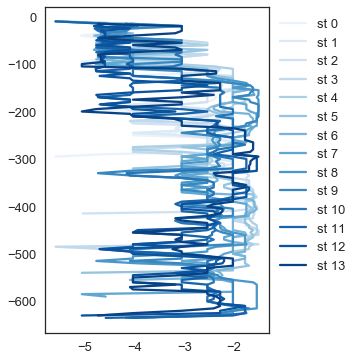

In [57]:
# Mask land values (=-6.1)
fig, ax = plt.subplots(1,1,figsize=(4,6))

labels = ['st %d' %ii for ii in range(np.shape(values_binned_masked)[1])]

sns.set_palette("Blues", 14)
for jj, lab in zip(range(np.shape(values_binned_masked)[1]), labels):
    ax.plot(values_binned_masked[:,jj],np.arange(-655,0,5), '-',label=lab)

ax.legend(bbox_to_anchor=(1,1))

In [58]:
# Find canyon bottom
dep_asc = np.arange(-655,0,5)
bot_asc = np.zeros(14) # bottom depth
bot_ind = np.zeros(14) # index of bottom depth

for ii in range(np.shape(values_binned_masked)[1]):
    mask = values_binned_masked[:,ii].mask
    dep_masked = np.ma.masked_array(dep_asc, mask = mask )
    bot_ind[ii] = np.argmin(dep_masked)
    bot_asc[ii] = dep_asc[np.argmin(dep_masked)]

Text(0.5,0,'log$_{10}$($K_{\\rho}$ / m$^2$s$^{-1}$)')

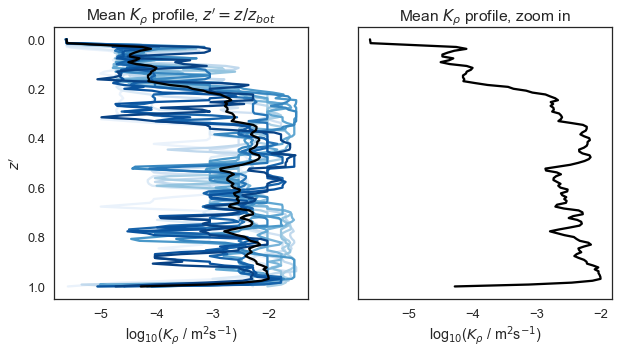

In [59]:
# Mean profile for Ascension, referenced to bottom
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

nz = 131
kp_norm_asc = np.empty((nz,14)) 
dep_norm_asc = np.linspace(0.0,1,nz)

for ii in range(np.shape(values_binned_masked)[1]):
    # interp
    F = interp.interp1d(dep_asc/bot_asc[ii], values_binned_masked[:,ii], 
                        fill_value='extrapolate')
    kp_norm_asc[:,ii] = F(dep_norm_asc)
    
    #plot
    ax1.plot(kp_norm_asc[:,ii],dep_norm_asc)

kp_mean_asc = np.nanmean(kp_norm_asc, axis=1) # final profile
ax1.plot(kp_mean_asc,dep_norm_asc, 'k-')
ax2.plot(kp_mean_asc,dep_norm_asc, 'k-')

ax1.invert_yaxis()
ax1.set_title(r'Mean $K_{\rho}$ profile, $z^{\prime}=z/z_{bot}$')
ax2.set_title(r'Mean $K_{\rho}$ profile, zoom in')
ax1.set_ylabel('$z^{\prime}$')
ax1.set_xlabel(r'log$_{10}$($K_{\rho}$ / m$^2$s$^{-1}$)')
ax2.set_xlabel(r'log$_{10}$($K_{\rho}$ / m$^2$s$^{-1}$)')

### Extract canyon rim depth

In [60]:
# Bin data into their original 14 stations along the canyon axis keeping the 
# nans to find the rim
size = np.shape(kvmap_masked)
kvmap_rim = np.zeros((int(size[0]/6),int(size[1]/92),4))

kk = 0

for ii in range(int(size[0]/6)):
    mm = 0
    for jj in range(int(size[1]/92)):
        kvmap_rim[ii,jj,0] = np.mean(kvmap_masked[kk:kk+6, mm:mm+92,0])
        kvmap_rim[ii,jj,1] = np.mean(kvmap_masked[kk:kk+6, mm:mm+92,1])
        kvmap_rim[ii,jj,2] = np.mean(kvmap_masked[kk:kk+6, mm:mm+92,2])
        kvmap_rim[ii,jj,3] = np.mean(kvmap_masked[kk:kk+6, mm:mm+92,3])
        mm = mm + 92
    kk = kk + 6

In [61]:
# Find canyon bottom
z_asc = np.arange(0,655,5)
rim_asc = np.zeros(14) # rim depth
rim_ind = np.zeros(14) # index of rim depth

for ii in range(np.shape(kvmap_rim)[1]-3):
    index_maskval = np.argwhere(np.isnan(kvmap_rim[18:,ii,0]))
    rim_ind[ii] = np.min(index_maskval)+18
    rim_asc[ii] = z_asc[rim_ind[ii]]
   
for ii in range(11,14,1):
    index_maskval = np.argwhere(np.isnan(kvmap_rim[37:,ii,0]))
    rim_ind[ii] = np.min(index_maskval)+37
    rim_asc[ii] = z_asc[rim_ind[ii]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


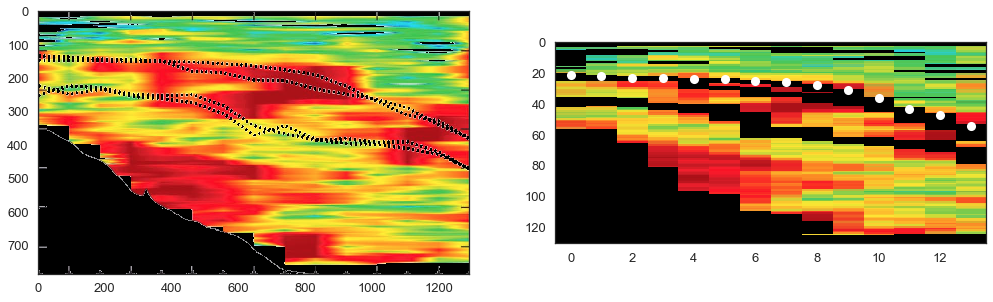

In [62]:
fig, ax = plt.subplots(1,2,figsize=(17,9))
ax[0].imshow(kvmap_masked.astype(int))
ax[1].imshow(kvmap_rim.astype(int), aspect=0.05)
ax[1].plot(rim_ind,'wo')
plt.show()

White dots correspond to the indices of the upper the rim that I found.

Text(0.5,0,'log$_{10}$($K_{\\rho}$ / m$^2$s$^{-1}$)')

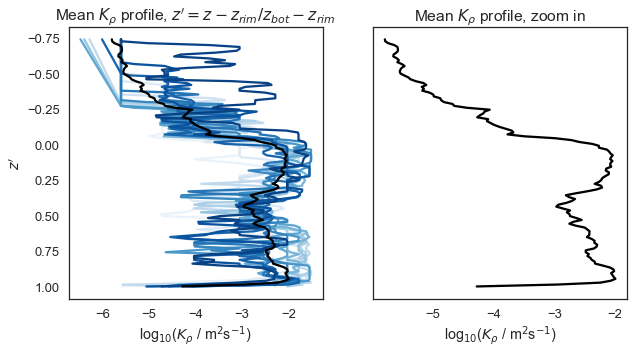

In [63]:
# Mean profile for Ascension, referenced to bottom and rim
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

nz = 131
kp_norm_asc_rim = np.empty((nz,14)) 
dep_norm_asc_rim = np.linspace(-0.74,1,nz) #-0.74 corresponds to z=0

for ii in range(np.shape(values_binned_masked)[1]):
    # interp, rim_asc is positive so I added it instead of subtracting it
    F = interp.interp1d((dep_asc+rim_asc[ii])/(bot_asc[ii]+rim_asc[ii]), 
                        values_binned_masked[:,ii], 
                        fill_value='extrapolate')
    kp_norm_asc_rim[:,ii] = F(dep_norm_asc_rim)
    
    #plot
    ax1.plot(kp_norm_asc_rim[:,ii],dep_norm_asc_rim)

kp_mean_asc_rim = np.nanmean(kp_norm_asc_rim, axis=1) # final profile
ax1.plot(kp_mean_asc_rim,dep_norm_asc_rim, 'k-')
ax2.plot(kp_mean_asc_rim,dep_norm_asc_rim, 'k-')

ax1.invert_yaxis()
ax1.set_title(r'Mean $K_{\rho}$ profile, $z^{\prime}=z-z_{rim}/z_{bot}-z_{rim}$')
ax2.set_title(r'Mean $K_{\rho}$ profile, zoom in')
ax1.set_ylabel('$z^{\prime}$')
ax1.set_xlabel(r'log$_{10}$($K_{\rho}$ / m$^2$s$^{-1}$)')
ax2.set_xlabel(r'log$_{10}$($K_{\rho}$ / m$^2$s$^{-1}$)')

In [64]:
# Save profiles
raw_data1 = {'depth':dep_norm_asc ,'kp':kp_mean_asc}
df1 = pd.DataFrame(raw_data1, columns = ['depth' ,'kp'])
filename1 = ('/ocean/kramosmu/Data/mean_kp_Ascension.csv')
df1.to_csv(filename1)

raw_data1rim = {'depth' :dep_norm_asc_rim ,'kp': kp_mean_asc_rim}
df1rim = pd.DataFrame(raw_data1rim, columns = ['depth' ,'kp'])
filename1rim = ('/ocean/kramosmu/Data/mean_rim_kp_Ascension.csv')
df1rim.to_csv(filename1rim)

print('Mean Kp profile files are: \n %s \n %s' %(filename1, filename1rim))

Mean Kp profile files are: 
 /ocean/kramosmu/Data/mean_kp_Ascension.csv 
 /ocean/kramosmu/Data/mean_rim_kp_Ascension.csv
